In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Optimisation de la position de la caméra à l'aide du rendu différentiable

Dans ce tutoriel, nous allons apprendre la position [x, y, z] d'une caméra à partir d'une image de référence en utilisant le rendu différentiable.

Nous allons d'abord initialiser un moteur de rendu avec une position de départ pour la caméra. Nous l'utiliserons ensuite pour générer une image, calculer une perte avec l'image de référence, et enfin rétropropager à travers l'ensemble du pipeline pour mettre à jour la position de la caméra.

Ce tutoriel montre comment
- charger un maillage à partir d'un fichier `.obj`.
- initialiser une `Caméra`, un `Shader` et un `Renderer`,
- effectuer le rendu d'un maillage
- mettre en place une boucle d'optimisation avec une fonction de perte et un optimiseur

## 0. installer et importer des modules

Assurez-vous que `torch` et `torchvision` sont installés. Si `pytorch3d` n'est pas installé, installez-le en utilisant la cellule suivante :

In [2]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=fefb7381a94399ac37d0c780ea1f6275b337f9fc1762f229491572b0b0a4c98f
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=8e719216ffa6b09b7fd4f5f058892297ccddfe14d381dfbfe6516c5d96a7418f
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 80.5 MB/s eta 0:00:00


In [3]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

## 1. Charger l'Obj

Nous allons charger un fichier obj et créer un objet **Meshes**. **Meshes** est une structure de données unique fournie dans PyTorch3D pour travailler avec **des lots de maillages de différentes tailles**. Elle possède plusieurs méthodes de classe utiles qui sont utilisées dans le pipeline de rendu.

Si vous exécutez ce notebook localement après avoir cloné le dépôt PyTorch3D, le maillage sera déjà disponible. **Si vous utilisez Google Colab, récupérez le maillage et sauvegardez-le dans le chemin `data/`** :

In [4]:
!mkdir -p data
!wget -P data https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

--2023-12-03 08:47:53--  https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.114, 52.84.251.15, 52.84.251.27, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: ‘data/teapot.obj’

teapot.obj          100%[===================>] 149.02K  --.-KB/s    in 0.004s  

2023-12-03 08:47:54 (38.2 MB/s) - ‘data/teapot.obj’ saved [152595/152595]



In [5]:
# Set the cuda device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Charger l'objet et ignorer les textures et les matériaux.
verts, faces_idx, _ = load_obj("./data/teapot.obj")
faces = faces_idx.verts_idx

# Initialiser chaque sommet pour qu'il soit de couleur blanche.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Créer un objet Meshes pour la théière. Ici, nous n'avons qu'une seule maille dans le lot.
teapot_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


## 2. Configuration de l'optimisation

### Créer un moteur de rendu

Un **rendu** dans PyTorch3D est composé d'un **rasterizer** et d'un **shader** qui ont chacun un certain nombre de sous-composants tels qu'une **caméra** (orthographique/perspective). Ici, nous initialisons certains de ces composants et utilisons des valeurs par défaut pour le reste.

Pour optimiser la position de la caméra, nous utiliserons un moteur de rendu qui produit une **silhouette** de l'objet uniquement et n'applique aucun **éclairage** ou **ombre**. Nous initialiserons également un autre moteur de rendu qui applique l'ombrage **Phong** complet et l'utiliserons pour visualiser les résultats.

In [6]:
# Initialiser une caméra en perspective.
cameras = FoVPerspectiveCameras(device=device)

# Pour mélanger les 100 visages, nous définissons quelques paramètres qui contrôlent l'opacité et la netteté des bords.
# bords. Reportez-vous à blending.py pour plus de détails.
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Définir les paramètres de tramage et d'ombrage. Ici, nous définissons l'image de sortie comme étant de taille
# 256x256. Pour former l'image mélangée, nous utilisons 100 visages pour chaque pixel. Nous avons également fixé bin_size et max_faces_per_bin à None, ce qui garantit que
# la méthode de rastérisation plus rapide, de grossier à fin, est utilisée. Référez-vous à rasterize_meshes.py pour # des explications sur ces paramètres.
# explications de ces paramètres. Référez-vous à docs/notes/renderer.md pour une explication de
# la différence entre la rastérisation naïve et la rastérisation grossière à fine.
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=100,
)

# Créer un moteur de rendu de maillage de silhouettes en composant un rasterizer et un shader.
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# Nous allons également créer un moteur de rendu Phong. Celui-ci est plus simple et n'a besoin de rendre qu'un visage par pixel.
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=0.0,
    faces_per_pixel=1,
)
# Nous pouvons ajouter une lumière ponctuelle devant l'objet.
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

### Créer une image de référence

Nous allons d'abord positionner la théière et générer une image. Nous utilisons des fonctions d'aide pour faire pivoter la théière jusqu'au point de vue souhaité. Nous pouvons ensuite utiliser les moteurs de rendu pour produire une image. Ici, nous utiliserons les deux moteurs de rendu pour visualiser la silhouette et l'image entièrement ombrée.

Le système de coordonnées mondiales est défini par +Y vers le haut, +X vers la gauche et +Z vers l'intérieur. En coordonnées mondiales, le bec de la théière est orienté vers la gauche.

Nous avons défini une caméra qui est positionnée sur l'axe z positif et qui voit donc le bec vers la droite.

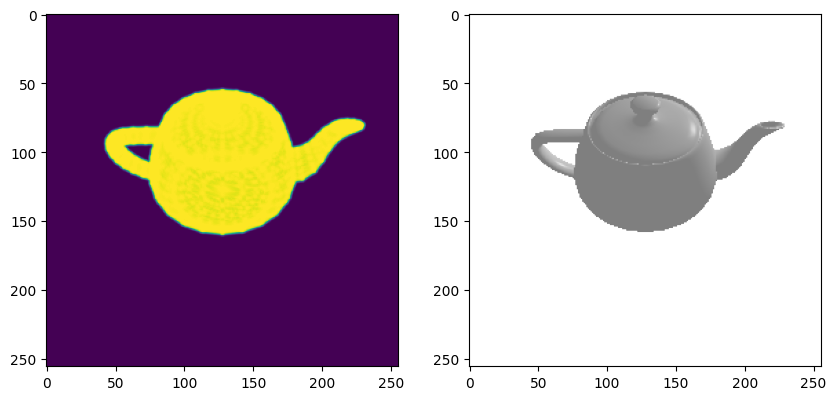

In [7]:
# Sélection du point de vue à l'aide d'angles sphériques
distance = 3   # Distance entre la caméra et l'objet
elevation = 50.0   # Angle d'élévation en degrés
azimuth = 0.0  # Pas de rotation, la caméra est donc positionnée sur l'axe +Z.

# Obtenir la position de la caméra en fonction des angles sphériques
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Rendre la théière en fournissant les valeurs de R et T.
silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouette.squeeze()[..., 3])  # ne tracer que le canal alpha de l'image RGBA
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

### Mise en place d'un modèle de base

Nous créons ici une classe de modèle simple et initialisons un paramètre pour la position de la caméra.

In [8]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer

        # Obtenir la silhouette de l'image RVB de référence en trouvant toutes les valeurs de pixels non blancs.
        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)

        # Créer un paramètre optimisable pour la position x, y, z de la caméra.
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0,  6.9, +2.5], dtype=np.float32)).to(meshes.device))

    def forward(self):

        # Rendez l'image en utilisant la position actualisée de la caméra. Sur la base de la nouvelle position de la
        # caméra, nous calculons les matrices de rotation et de translation
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)

        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)

        # Calculer la perte de silhouette
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
        return loss, image


## 3. Initialiser le modèle et l'optimiseur

Nous pouvons maintenant créer une instance du **modèle** ci-dessus et mettre en place un **optimiseur** pour le paramètre de position de la caméra.

In [9]:
# Nous allons enregistrer des images périodiquement et les composer en un GIF.
filename_output = "./teapot_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialiser un modèle en utilisant le moteur de rendu, le maillage et l'image de référence
model = Model(meshes=teapot_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)

# Créer un optimiseur. Ici, nous utilisons Adam et nous passons les paramètres du modèle
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

### Visualize the starting position and the reference position

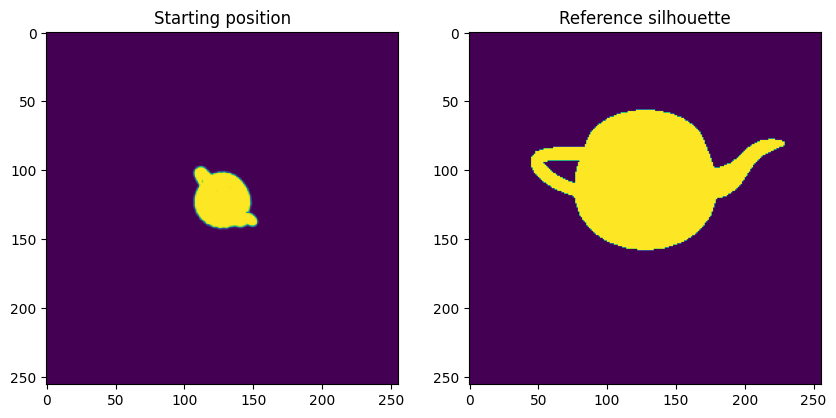

In [10]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");


## 4. Exécuter l'optimisation

Nous exécutons plusieurs itérations de la passe avant et arrière et sauvegardons les résultats toutes les 10 itérations. Une fois l'opération terminée, jetez un oeil à `./teapot_optimization_demo.gif` pour voir une belle image du processus d'optimisation !

  0%|          | 0/200 [00:00<?, ?it/s]

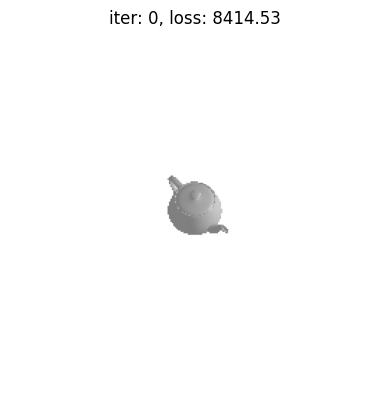

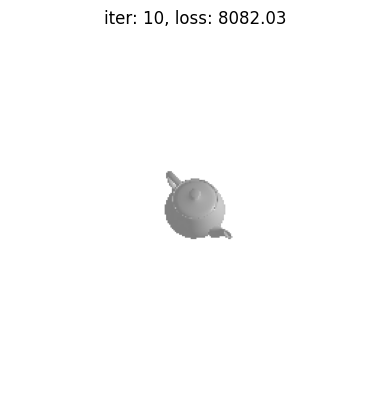

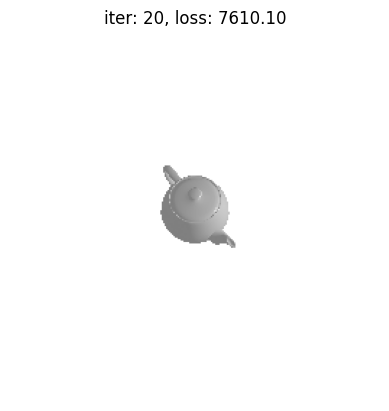

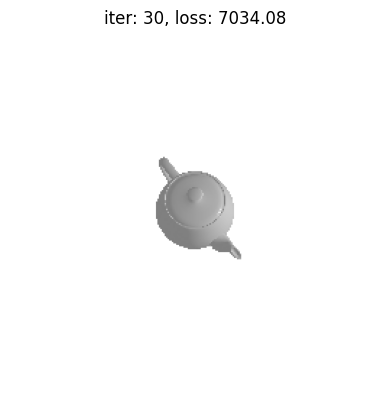

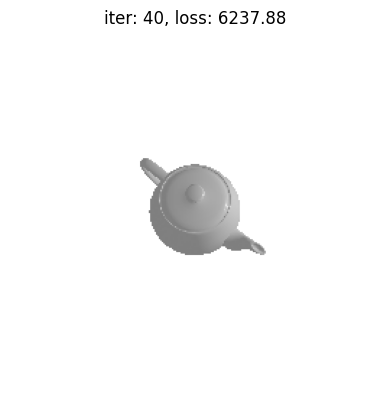

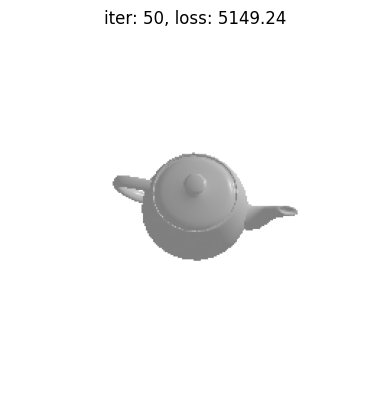

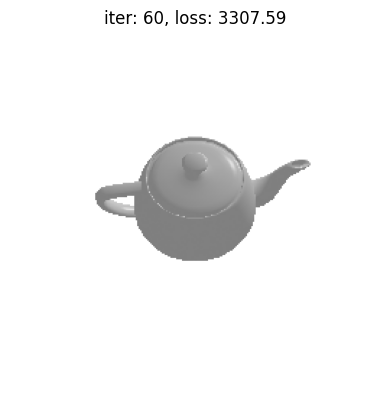

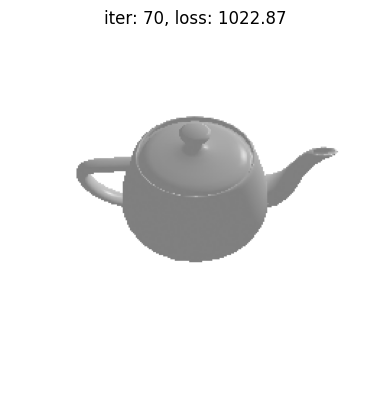

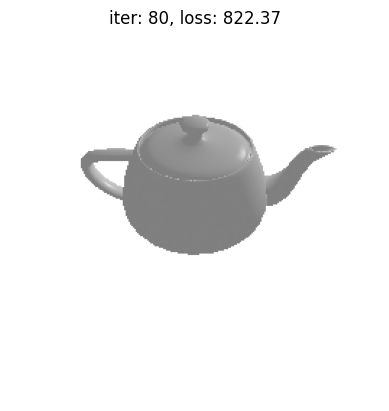

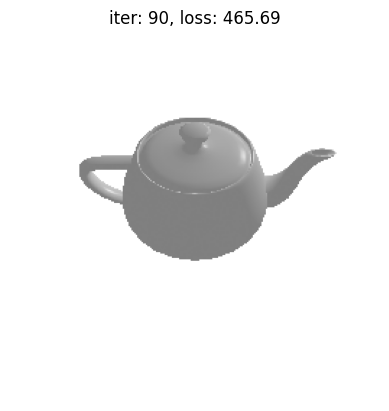

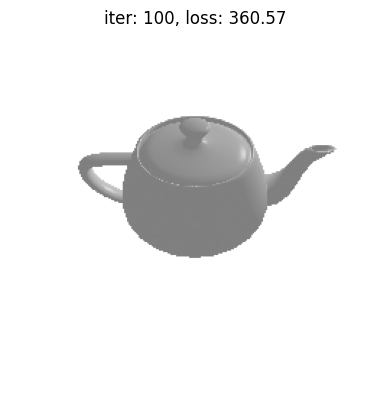

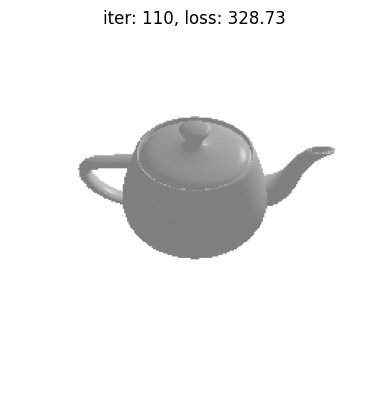

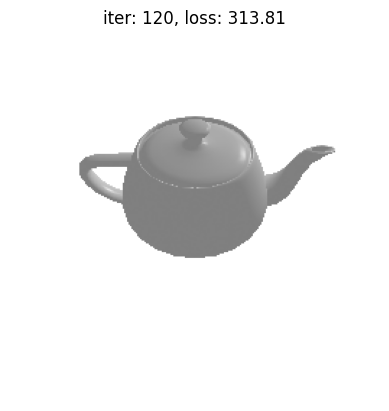

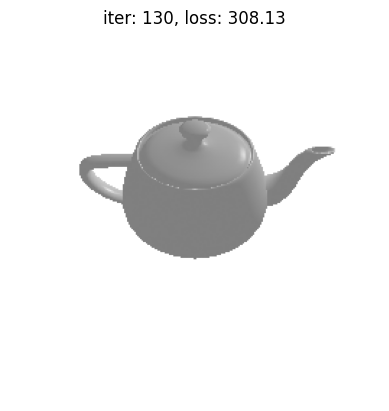

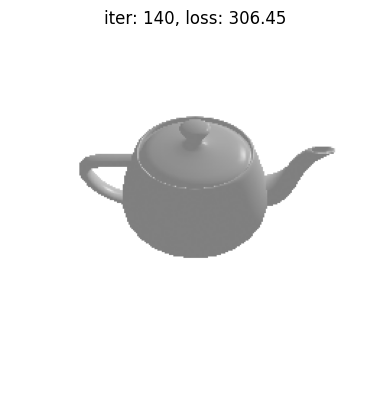

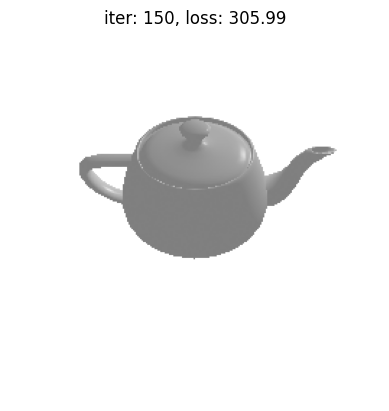

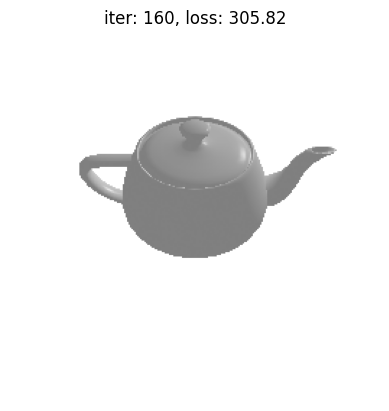

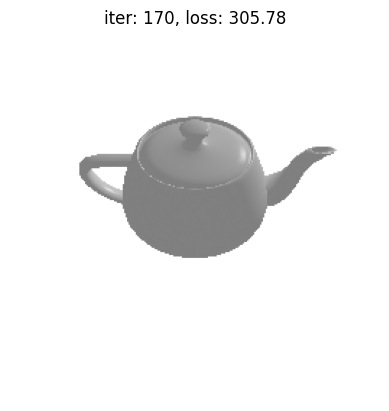

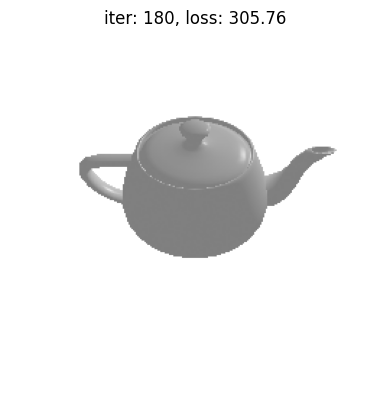

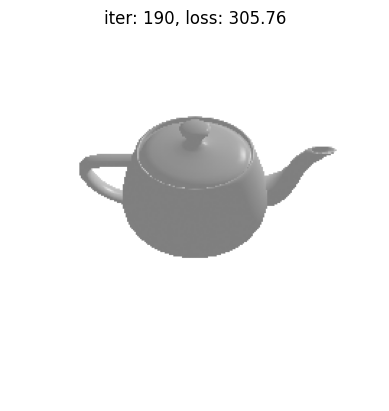

In [11]:
loop = tqdm(range(200))
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()

    loop.set_description('Optimizing (loss %.4f)' % loss.data)

    if loss.item() < 200:
        break

    # Enregistrer les résultats pour créer un GIF.
    if i % 10 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)

        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.axis("off")

writer.close()